In [1]:
import nengo
import nengo.spa as spa

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from utils import gen_vecs
from data_feed import BasicDataFeed

import itertools
import random

In [2]:
n_items = 4
t_present = 0.5
pause = 0.1
D = 16
dt = 0.001
similarity = 0.9999

recog_neurons = 500
seed = 0
spikes_synapse = 0.005

t_train = (t_present+pause)*n_items
t_test = 2*(t_present+pause)*n_items

In [3]:
vocab = spa.Vocabulary(D)

targ_class = []

stim_vecs = gen_vecs(n_items, D, similarity)
stim_lbl = []

for v_i, vec in enumerate(stim_vecs):
    lbl = "S%d" % v_i
    stim_lbl.append(lbl)
    vocab.add(lbl, vec)

    targ = np.zeros(n_items)
    targ[v_i] = 1
    targ_class.append(targ)

print(stim_lbl)

for s1, s2 in itertools.combinations(stim_lbl, 2):
    print(np.dot(vocab.parse(s1).v, vocab.parse(s2).v))

['S0', 'S1', 'S2', 'S3']
0.9999
0.9999
0.9999
0.9999
0.9999
0.9999


In [6]:
def vocab_feed(idx, t):
    return vocab.parse(stim_lbl[idx]).v

# Baseline

In [112]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    
    nengo.Connection(in_nd, recog, synapse=None)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_filt_spikes = nengo.Probe(recog.neurons, synapse=spikes_synapse)
    p_cor = nengo.Probe(cor)

In [113]:
with nengo.Simulator(model) as sim:
    sim.run(t_train)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


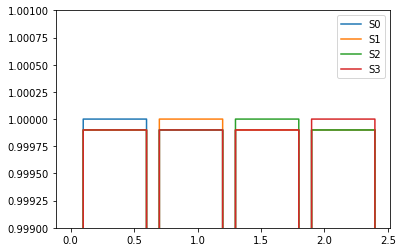

In [118]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.ylim(0.999, 1.001)
plt.legend(stim_lbl)

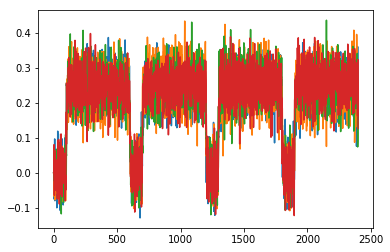

In [119]:
solver = nengo.solvers.LstsqL2(reg=0.02)
decoders, stats = solver(sim.data[p_filt_spikes], sim.data[p_cor])
plt.plot(np.dot(sim.data[p_filt_spikes], decoders))

## Test in actual network

In [120]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)
    out_nd = nengo.Node(size_in=n_items)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    
    nengo.Connection(in_nd, recog, synapse=None)
    nengo.Connection(recog.neurons, out_nd, transform=decoders.T, synapse=0.01)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_out = nengo.Probe(out_nd, synapse=0.01)

In [121]:
with nengo.Simulator(model) as sim:
    sim.run(t_test)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


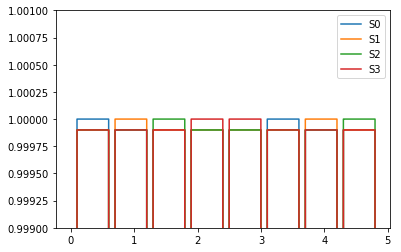

In [122]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.ylim(0.999, 1.001)
plt.legend(stim_lbl)

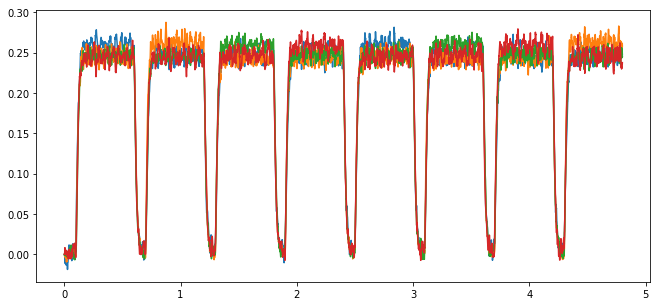

In [101]:
plt.figure(figsize=(11, 5))
plt.plot(sim.trange(), sim.data[p_out])

# Associative Memory Baseline

In [46]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)

    recog = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, threshold=similarity, seed=seed)
    recog.add_wta_network()
    
    nengo.Connection(in_nd, recog.input, synapse=None)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_out = nengo.Probe(recog.output, synapse=0.01)

In [47]:
with nengo.Simulator(model) as sim:
    sim.run(t_present*n_items)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


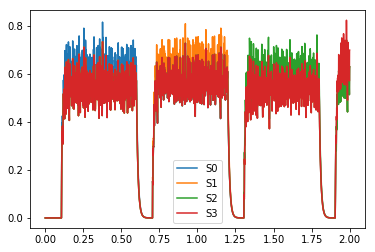

In [48]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], stim_vecs))
plt.legend(stim_lbl)

# Decoding directly from oscillator

In [123]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, seed=seed)
    
    nengo.Connection(in_nd, recog, seed=seed, synapse=None)
    nengo.Connection(recog, cleanup.input, seed=seed)
    nengo.Connection(cleanup.output, recog, transform=-10, seed=seed)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_osc = nengo.Probe(recog, synapse=0.01)
    p_filt_spikes = nengo.Probe(recog.neurons, synapse=spikes_synapse)
    p_cor = nengo.Probe(cor)

In [124]:
with nengo.Simulator(model) as sim:
    sim.run(3*t_train)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:04.                                                 


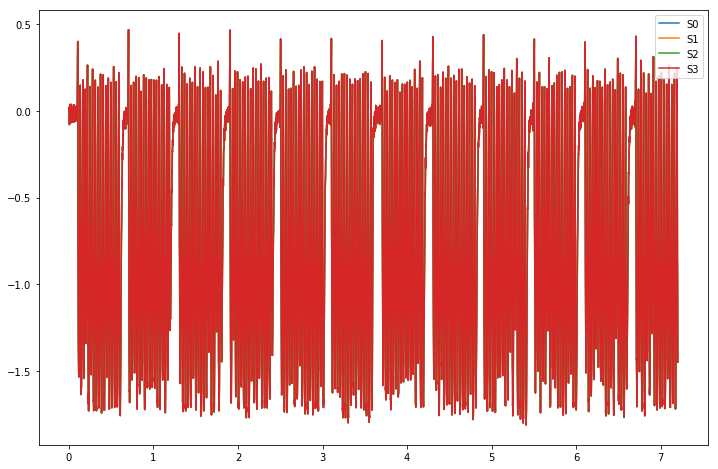

In [125]:
plt.figure(figsize=(12,8))
plt.plot(sim.trange(), spa.similarity(sim.data[p_osc], stim_vecs))
plt.legend(stim_lbl)

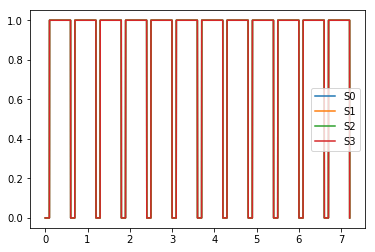

In [126]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

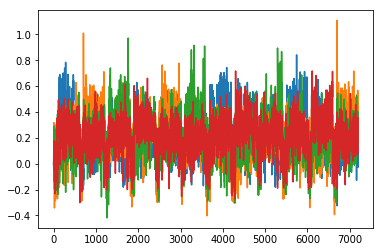

In [127]:
solver = nengo.solvers.LstsqL2(reg=0.02)
decoders, stats = solver(sim.data[p_filt_spikes], sim.data[p_cor])
plt.plot(np.dot(sim.data[p_filt_spikes], decoders))

## Test in actual network

In [128]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)
    out_nd = nengo.Node(size_in=n_items)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, seed=seed)
    
    nengo.Connection(in_nd, recog, seed=seed, synapse=None)
    nengo.Connection(recog, cleanup.input, seed=seed)
    nengo.Connection(cleanup.output, recog, transform=-10, seed=seed)
    nengo.Connection(recog.neurons, out_nd, transform=decoders.T, synapse=0.01)
    
    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(out_nd, synapse=0.01)

In [129]:
with nengo.Simulator(model) as sim:
    sim.run(t_test)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:04.                                                 


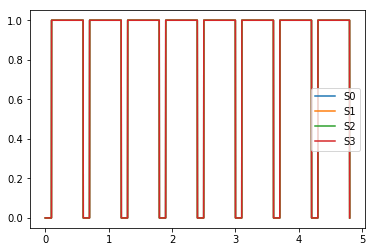

In [130]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

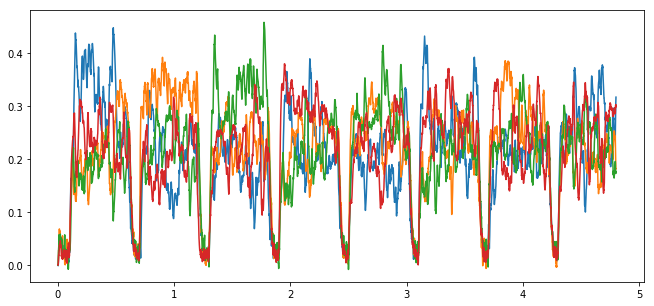

In [131]:
plt.figure(figsize=(11, 5))
plt.plot(sim.trange(), sim.data[p_out])

# Decoding directly from oscillator with pos gain

In [121]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, seed=seed)
    
    nengo.Connection(in_nd, recog, seed=seed, synapse=None)
    nengo.Connection(recog, cleanup.input, seed=seed)
    nengo.Connection(cleanup.output, recog, transform=10, seed=seed)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_osc = nengo.Probe(recog, synapse=0.01)
    p_filt_spikes = nengo.Probe(recog.neurons, synapse=spikes_synapse)
    p_cor = nengo.Probe(cor)

In [122]:
with nengo.Simulator(model) as sim:
    sim.run(t_train)

Building finished in 0:00:02.                                                                                                                                
Simulating finished in 0:00:16.                                                                                                                              


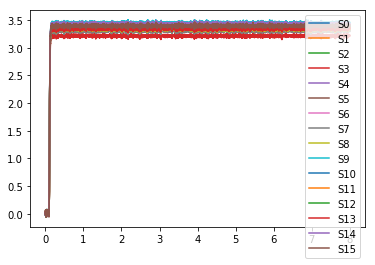

In [123]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_osc], stim_vecs))
plt.legend(stim_lbl)

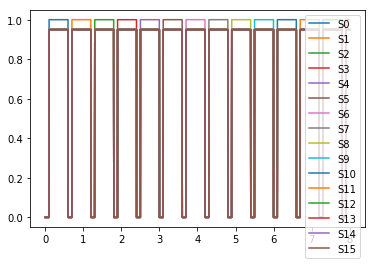

In [124]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

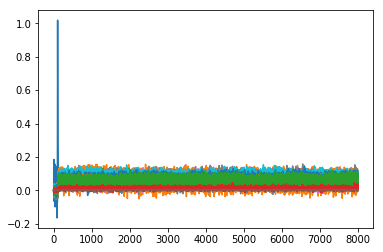

In [125]:
solver = nengo.solvers.LstsqL2(reg=0.02)
decoders, stats = solver(sim.data[p_filt_spikes], sim.data[p_cor])
plt.plot(np.dot(sim.data[p_filt_spikes], decoders))

## Test in actual network

In [126]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)
    out_nd = nengo.Node(size_in=n_items)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, seed=seed)
    
    nengo.Connection(in_nd, recog, seed=seed, synapse=None)
    nengo.Connection(recog, cleanup.input, seed=seed)
    nengo.Connection(cleanup.output, recog, transform=10, seed=seed)
    nengo.Connection(recog.neurons, out_nd, transform=decoders.T, synapse=0.01)
    
    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(out_nd, synapse=0.01)

In [127]:
with nengo.Simulator(model) as sim:
    sim.run(t_test)

Building finished in 0:00:01.                                                                                                                                
Simulating finished in 0:00:34.                                                                                                                              


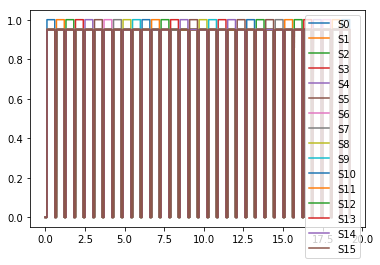

In [128]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

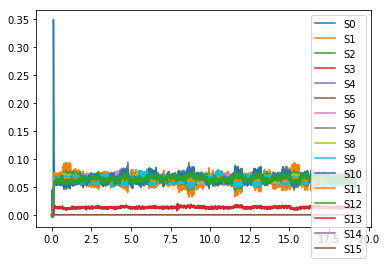

In [129]:
plt.plot(sim.trange(), sim.data[p_out])
plt.legend(stim_lbl)

# Decoding from temporal network

In [4]:
class Delay(object):

    def __init__(self, dimensions, timesteps=50):
        self.history = np.zeros((timesteps, dimensions))

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x
        return self.history[0]

In [7]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)
delay = Delay(D, timesteps=int(0.1 / dt))

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    recog_out = nengo.Ensemble(2*recog_neurons, 2*D, seed=seed)
    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, seed=seed)

    delay_nd = nengo.Node(delay.step, size_in=D, size_out=D)
    
    nengo.Connection(in_nd, recog, seed=seed, synapse=None)
    nengo.Connection(recog, cleanup.input, seed=seed)
    nengo.Connection(cleanup.output, recog, transform=-10, seed=seed)
    
    nengo.Connection(recog, recog_out[:D])
    nengo.Connection(recog, delay_nd)
    nengo.Connection(delay_nd, recog_out[D:])
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_osc = nengo.Probe(recog, synapse=0.01)
    p_filt_spikes = nengo.Probe(recog_out.neurons, synapse=spikes_synapse)
    p_cor = nengo.Probe(cor)

In [8]:
with nengo.Simulator(model) as sim:
    sim.run(t_train)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:06.                                                 


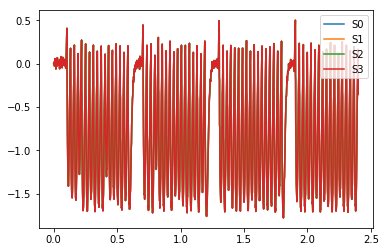

In [9]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_osc], stim_vecs))
plt.legend(stim_lbl)

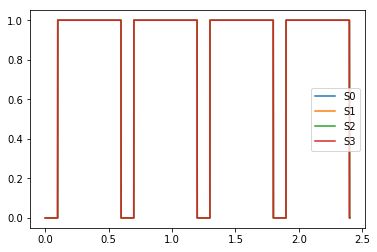

In [10]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

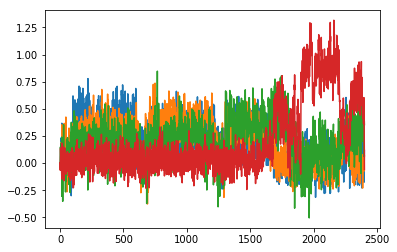

In [11]:
solver = nengo.solvers.LstsqL2(reg=0.02)
decoders, stats = solver(sim.data[p_filt_spikes], sim.data[p_cor])
plt.plot(np.dot(sim.data[p_filt_spikes], decoders))

## Test in actual network

In [14]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)
delay = Delay(D, timesteps=int(0.1 / dt))

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)
    out_nd = nengo.Node(size_in=n_items)

    recog = nengo.Ensemble(recog_neurons, D, seed=seed)
    recog_out = nengo.Ensemble(2*recog_neurons, 2*D, seed=seed)
    cleanup = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, seed=seed)

    delay_nd = nengo.Node(delay.step, size_in=D, size_out=D)
    
    nengo.Connection(in_nd, recog, seed=seed, synapse=None)
    nengo.Connection(recog, cleanup.input, seed=seed)
    nengo.Connection(cleanup.output, recog, transform=-10, seed=seed)
    
    nengo.Connection(recog, recog_out[:D])
    nengo.Connection(recog, delay_nd)
    nengo.Connection(delay_nd, recog_out[D:])
    
    nengo.Connection(recog_out.neurons, out_nd, transform=decoders.T, synapse=0.01)
    
    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(out_nd, synapse=0.01)

In [15]:
with nengo.Simulator(model) as sim:
    sim.run(t_test)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


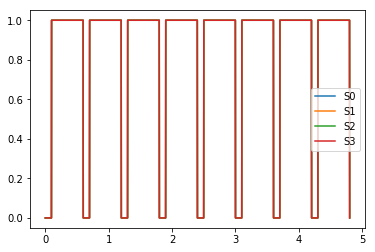

In [16]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.legend(stim_lbl)

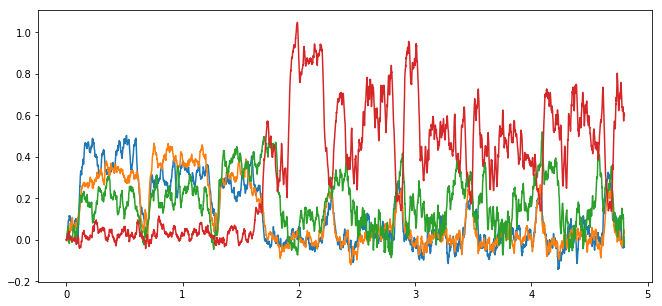

In [17]:
plt.figure(figsize=(11, 5))
plt.plot(sim.trange(), sim.data[p_out])